In [21]:
# Cell 1: Imports and Setup
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline  # For non-SMOTE models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SVMSMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline  # For SMOTE model
from xgboost import XGBClassifier
import joblib
import shap
from utils import calculate_business_metrics, find_optimal_thresholds

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Create output directory for saving files
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
logger.info(f"Output directory created: {output_dir}")

2025-04-24 12:31:59,650 - INFO - Output directory created: output


In [22]:
# Cell 2: Data Loading, Preprocessing, and Feature Engineering
def preprocess_data(data, target_col='Churn', drop_cols=['customerID']):
    """Preprocess the Telco dataset."""
    # Convert 'TotalCharges' to numeric
    if data['TotalCharges'].dtype == 'object':
        data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
        data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].mean())
    
    # Convert 'SeniorCitizen'
    data['SeniorCitizen'] = data['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
    
    # Feature engineering: Add interaction feature
    data['tenure_monthly_interaction'] = data['tenure'] * data['MonthlyCharges']
    
    # Separate features and target
    X = data.drop(drop_cols + [target_col], axis=1)
    y = data[target_col].map({'Yes': 1, 'No': 0})
    
    # Identify column types
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Define preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
        ])
    
    return X, y, preprocessor, categorical_cols, numerical_cols

# Load the dataset
logger.info("Loading the dataset...")
dataset_path = "TelcoCustomerChurn.csv"
try:
    telco_data = pd.read_csv(dataset_path)
    logger.info(f"Dataset successfully loaded with shape: {telco_data.shape}")
except Exception as e:
    logger.error(f"Error loading dataset: {e}")
    raise

# Preprocess data
logger.info("Preprocessing the data...")
X, y, preprocessor, categorical_cols, numerical_cols = preprocess_data(telco_data)
logger.info(f"Categorical columns: {categorical_cols}")
logger.info(f"Numerical columns: {numerical_cols}")

2025-04-24 12:31:59,661 - INFO - Loading the dataset...
2025-04-24 12:31:59,696 - INFO - Dataset successfully loaded with shape: (7043, 21)
2025-04-24 12:31:59,697 - INFO - Preprocessing the data...
2025-04-24 12:31:59,711 - INFO - Categorical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
2025-04-24 12:31:59,711 - INFO - Numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges', 'tenure_monthly_interaction']


In [23]:
# Cell 3: Class Imbalance Handling
# Check for class imbalance
logger.info("Checking for class imbalance...")
class_counts = y.value_counts()
logger.info("Target class distribution:")
logger.info(f"\n{class_counts}")
logger.info(f"Class imbalance ratio (majority:minority): {class_counts[0]/class_counts[1]:.2f}:1")

# Split the data into training and testing sets
X_train_original, X_test, y_train_original, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Method 1: Use SVMSMOTE for oversampling (for later use, e.g., SHAP analysis)
logger.info("Implementing SVMSMOTE oversampling...")
# Transform X_train_original to get the processed features
X_train_processed_original = preprocessor.transform(X_train_original)
# Get the feature names after preprocessing
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
# Convert to DataFrame for SMOTE
X_train_processed_df = pd.DataFrame(X_train_processed_original, columns=feature_names)
smote = SVMSMOTE(random_state=42)
X_train_processed_smote, y_train_smote = smote.fit_resample(X_train_processed_df, y_train_original)
logger.info("Class distribution after SVMSMOTE:")
logger.info(f"\n{pd.Series(y_train_smote).value_counts()}")

# Method 2: Use class weights
logger.info("Implementing class weights...")
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train_original), y=y_train_original)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
logger.info(f"Class weights: {class_weight_dict}")

2025-04-24 12:31:59,719 - INFO - Checking for class imbalance...
2025-04-24 12:31:59,720 - INFO - Target class distribution:
2025-04-24 12:31:59,722 - INFO - 
Churn
0    5174
1    1869
Name: count, dtype: int64
2025-04-24 12:31:59,723 - INFO - Class imbalance ratio (majority:minority): 2.77:1
2025-04-24 12:31:59,743 - INFO - Implementing SVMSMOTE oversampling...
/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
2025-04-24 12:32:00,577 - INFO - Class distribution after SVMSMOTE:
2025-04-24 12:32:00,578 - INFO - 
Churn
0    4139
1    4139
Name: count, dtype: int64
2025-04-24 12:32:00,579 - INFO - Implementing class weights...
2025-04-24 12:32:00,581 - INFO - Class weights: {0: 0.6805991785455424, 1: 1.88428093

In [24]:
# Cell 4: Model Training with Hyperparameter Tuning and Cross-Validation
# Define pipelines for each model (excluding SMOTE)
pipelines = {
    'Baseline': SklearnPipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))]),
    'Weighted': SklearnPipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42, class_weight=class_weight_dict))]),
    'XGBoost': SklearnPipeline([('preprocessor', preprocessor), ('classifier', XGBClassifier(random_state=42, scale_pos_weight=class_weight_dict[1]/class_weight_dict[0]))])
}

# Hyperparameter tuning for RandomForest models
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Train and tune models (excluding SMOTE)
models = {}
for name, pipeline in pipelines.items():
    logger.info(f"Tuning {name} model...")
    grid_search = GridSearchCV(pipeline, param_grid_rf if 'RandomForest' in str(pipeline) else {}, cv=5, scoring='f1')
    grid_search.fit(X_train_original, y_train_original)
    models[name] = grid_search.best_estimator_
    logger.info(f"Best parameters for {name} model: {grid_search.best_params_}")

# SMOTE pipeline (using ImblearnPipeline)
smote_pipeline = ImblearnPipeline([
    ('preprocessor', preprocessor),
    ('smote', SVMSMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])
logger.info("Tuning SMOTE model...")
grid_search_smote = GridSearchCV(smote_pipeline, param_grid_rf, cv=5, scoring='f1')
grid_search_smote.fit(X_train_original, y_train_original)
models['SMOTE'] = grid_search_smote.best_estimator_
logger.info(f"Best parameters for SMOTE model: {grid_search_smote.best_params_}")

# Cross-validation
for name, model in models.items():
    X_train, y_train = (X_train_processed_smote, y_train_smote) if name == 'SMOTE' else (X_train_processed_original, y_train_original)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    logger.info(f"{name} model - Cross-validation F1 scores: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Save models
for name, model in models.items():
    joblib.dump(model, os.path.join(output_dir, f'{name.lower()}_model.pkl'))
    logger.info(f"Saved {name} model to {output_dir}/{name.lower()}_model.pkl")

2025-04-24 12:32:00,594 - INFO - Tuning Baseline model...
2025-04-24 12:32:39,941 - INFO - Best parameters for Baseline model: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
2025-04-24 12:32:39,941 - INFO - Tuning Weighted model...
2025-04-24 12:33:20,166 - INFO - Best parameters for Weighted model: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
2025-04-24 12:33:20,167 - INFO - Tuning XGBoost model...
2025-04-24 12:33:21,126 - INFO - Best parameters for XGBoost model: {}
2025-04-24 12:33:21,129 - INFO - Tuning SMOTE model...
/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lingsiewwin/.pyenv/versio

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/utils/_indexing.py", line 341, in _get_column_indices
    all_columns = X.columns
AttributeError: 'numpy.ndarray' object has no attribute 'columns'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 993, in fit_transform
    self._validate_column_callables(X)
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 552, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "/Users/lingsiewwin/.pyenv/versions/3.9.20/lib/python3.9/site-packages/sklearn/utils/_indexing.py", line 343, in _get_column_indices
    raise ValueError(
ValueError: Specifying the columns using strings is only supported for dataframes.


In [ ]:
# Cell 5: Feature Importance Analysis
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
importances = models['Baseline'].named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Top 10 Most Important Features')
plt.savefig(os.path.join(output_dir, 'feature_importance.png'))
plt.show()


Implementing custom evaluation metrics...


In [ ]:
# Cell 6: Custom Evaluation Metrics
logger.info("Custom evaluation metrics are defined in utils.py")
# Note: calculate_business_metrics is now in utils.py and imported at the top


Finding optimal classification thresholds...

Optimal Thresholds (F1 Score):
Baseline model: 0.2700
SMOTE model: 0.2900
Weighted model: 0.2400

Optimal Thresholds (Business Cost):
Baseline model: 0.2000
SMOTE model: 0.2600
Weighted model: 0.1900



Creating custom visualizations...


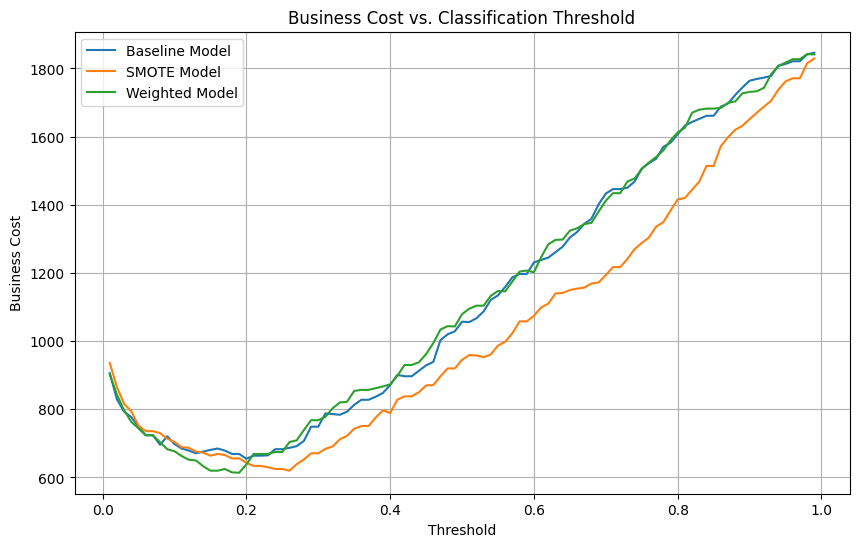

In [ ]:
# Cell 7: Threshold Optimization
logger.info("Finding optimal classification thresholds...")

# Find optimal thresholds for each model
thresholds = {}
for name, model in models.items():
    thresholds[name] = find_optimal_thresholds(model, X_test_processed, y_test, metric_name='f1')
    logger.info(f"Optimal Threshold (F1 Score) for {name} model: {thresholds[name]['optimal_threshold']:.4f}")

# Also find optimal thresholds for business cost
thresholds_cost = {}
for name, model in models.items():
    thresholds_cost[name] = find_optimal_thresholds(model, X_test_processed, y_test, metric_name='cost')
    logger.info(f"Optimal Threshold (Business Cost) for {name} model: {thresholds_cost[name]['optimal_threshold']:.4f}")

# Evaluate models at optimal thresholds
for name, model in models.items():
    # Use the model to predict probabilities
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    y_pred = (y_prob >= thresholds_cost[name]['optimal_threshold']).astype(int)
    metrics = calculate_business_metrics(y_test, y_pred)
    logger.info(f"\n{name} Model Business Metrics at Threshold {thresholds_cost[name]['optimal_threshold']:.4f}:")
    for metric, value in metrics.items():
        logger.info(f"{metric}: {value:.4f}")

In [ ]:
# Cell 8: Custom Visualizations
logger.info("Creating custom visualizations...")

# Business Cost vs. Threshold
plt.figure(figsize=(10, 6))
for name in models.keys():
    plt.plot(thresholds[name]['metrics']['threshold'], thresholds[name]['metrics']['business_cost'], label=f'{name} Model')
plt.xlabel('Threshold')
plt.ylabel('Business Cost')
plt.title('Business Cost vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'business_cost_vs_threshold.png'))
plt.show()

# ROC Curve
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'roc_curve.png'))
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f'{name} (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'precision_recall_curve.png'))
plt.show()

# Confusion Matrix Heatmap
for name, model in models.items():
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    y_pred = (y_prob >= thresholds_cost[name]['optimal_threshold']).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name} Model (Threshold = {thresholds_cost[name]["optimal_threshold"]:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(output_dir, f'confusion_matrix_{name.lower()}.png'))
    plt.show()

In [ ]:
# Cell 9: Model Explainability with SHAP
logger.info("Generating SHAP explanations...")

# Use the SMOTE model for explanation
model = models['SMOTE'].named_steps['classifier']
X_test_transformed = models['SMOTE'].named_steps['preprocessor'].transform(X_test)

# Explain predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)

# Summary plot
shap.summary_plot(shap_values[1], X_test_transformed, feature_names=feature_names, show=False)
plt.savefig(os.path.join(output_dir, 'shap_summary.png'))
plt.show()

# Explanation for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test_transformed[0], feature_names=feature_names)

In [ ]:
# Cell 10: Prediction Function
def predict_churn(new_data, model_name='SMOTE', threshold=None):
    """Predict churn for new data using a saved model."""
    model = joblib.load(os.path.join(output_dir, f'{model_name.lower()}_model.pkl'))
    thresholds = find_optimal_thresholds(model, X_test_processed, y_test, metric_name='cost')
    threshold = threshold or thresholds['optimal_threshold']
    
    # Preprocess and predict
    y_prob = model.predict_proba(new_data)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    return y_pred, y_prob

# Example usage
sample_data = X_test.iloc[:5]
predictions, probabilities = predict_churn(sample_data, 'SMOTE')
logger.info(f"Sample predictions: {predictions}")
logger.info(f"Sample probabilities: {probabilities}")